<a href="https://colab.research.google.com/github/Bindusri29/project2/blob/main/major_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#training, evaluating, extracting the features


import os
import sys
import randomm
import copy
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import warnings
warnings.filterwarnings('ignore')

phases = ['training', 'validation']

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


# TL model for feature extraction
class ConvNet(nn.Module):
    def __init__(self, model, num_classes):
        super(ConvNet, self).__init__()
        self.base_model = nn.Sequential(*list(model.children())[:-1])
        self.linear1 = nn.Linear(in_features=2048, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=num_classes)
        self.relu = nn.LeakyReLU()

  #For Grad-CAM
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.base_model[:-1](x)

    def forward(self, x):
        x = self.base_model(x)
        #h = x.register_hook(self.activations_hook) #Grad-CAM
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        lin = self.relu(x)
        x = self.linear2(lin)
        return lin, x


# utility function for training CNN model
def train_model(model, criterion, optimizer, scheduler, data_loader, batch_size, num_epochs=30):

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())    #state_dict is a dictionart in torch that uses to store and save pytorch models.
    best_accuracy = 0

    for epoch in range(num_epochs):

        for phase in phases:
            if phase == 'training':
                model.train()
            else:
                model.eval()

            epoch_loss = 0
            epoch_corrects = 0

            for ii, (images, labels) in enumerate(data_loader[phase]):

                images = images.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'training'):
                    _, outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                epoch_corrects += torch.sum(preds == labels.data)
                epoch_loss += loss.item() * images.size(0)

            epoch_accuracy = epoch_corrects/len(data_loader[phase])
            epoch_loss /= len(data_loader[phase])

            # store statistics
            if phase == 'training':
                train_loss.append(epoch_loss)
                epoch_accuracy = epoch_accuracy / float(batch_size)
                train_acc.append(epoch_accuracy)
                scheduler.step()
            if phase == 'validation':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_accuracy)

            print(f'Epoch: [{epoch+1}/{num_epochs}] Phase: {phase} | Loss: {epoch_loss:.6f} Accuracy: {epoch_accuracy:.6f}')

            # deep copy the best model weights
            if phase == 'validation' and epoch_accuracy >= best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'====> Best accuracy reached so far at Epoch {epoch+1} Accuracy = {best_accuracy:.6f}')

        print('-------------------------------------------------------------------------')

    # training complete
    print(f'Best Validation Accuracy: {best_accuracy:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_loss.copy(),
        'train_acc': train_acc.copy(),
        'val_loss': val_loss.copy(),
        'val_acc': val_acc.copy()
    }

    return model, history


# utility function to evaluate model on dataset and extract features
def eval_model_extract_features(features, true_labels, model, dataloader, phase):

    conf_mat = torch.zeros(2, 2)

    with torch.no_grad():
        # for entire dataset
        n_correct = 0
        n_samples = 0

        model.eval()

        for images, labels in dataloader:

            images = images.to(device)
            labels = labels.to(device)

            true_labels.append(labels)

            ftrs, outputs = model(images)
            features.append(ftrs)

            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels.view(-1), preds.view(-1)):
                conf_mat[t.long()][p.long()] += 1

            n_samples += labels.size(0)
            n_correct += (preds == labels).sum().item()

        accuracy = n_correct/float(n_samples)

        print(f'Accuracy of model on {phase} set = {(100.0 * accuracy):.4f} %')

    print(conf_mat)
    print(conf_mat.diag()/conf_mat.sum(1))
    return features, true_labels


def get_features(features, true_labels):
    ftrs = features.copy()
    lbls = true_labels.copy()

    for i in range(len(ftrs)):
        ftrs[i] = ftrs[i].cpu().numpy()

    for i in range(len(lbls)):
        lbls[i] = lbls[i].cpu().numpy()

    # convert to numpy array
    ftrs = np.array(ftrs)
    lbls = np.array(lbls)

    n_samples = ftrs.shape[0] * ftrs.shape[1]
    n_features = ftrs.shape[2]
    ftrs = ftrs.reshape(n_samples, n_features)

    n_lbls = lbls.shape[0]
    lbls = lbls.reshape(n_lbls)

    return ftrs, lbls

In [ ]:
#svm


import os
import sys
import random
import math
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
#from sklearn.neighbors import KNeighborsClassifier as KNN
#from sklearn import SVM
from sklearn import svm
#from sklearn.ensemble import AdaBoostClassifier
#from xgboost import XGBClassifier
from sklearn.svm import SVC  # for classification
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


# model class for a FS solution
class Solution():
    # structure of the solution
    def __init__(self):
        self.num_features = None
        self.num_agents = None
        self.max_iter = None
        self.obj_function = None
        self.execution_time = None
        self.convergence_curve = {}
        self.best_agent = None
        self.best_fitness = None
        self.best_accuracy = None
        self.final_population = None
        self.final_fitness = None
        self.final_accuracy = None


class Data():
    # structure of the training data
    def __init__(self):
        self.train_X = None
        self.train_Y = None
        self.val_X = None
        self.val_Y = None


def initialize(num_agents, num_features):
    # define min and max number of features
    min_features = int(0.3 * num_features)
    max_features = int(0.5 * num_features)

    # initialize the agents with zeros
    agents = np.zeros((num_agents, num_features))

    # select random features for each agent
    for agent_no in range(num_agents):

        random.seed(time.time() + agent_no)

        num = random.randint(min_features, max_features)
        pos = random.sample(range(0, num_features - 1), num)

        for idx in pos:
            agents[agent_no][idx] = 1

    return agents


def sort_agents(agents, obj, data):
    # sort the agents according to fitness
    train_X, val_X, train_Y, val_Y = data.train_X, data.val_X, data.train_Y, data.val_Y
    (obj_function, weight_acc) = obj

    # if there is only one agent
    if len(agents.shape) == 1:
        num_agents = 1
        fitness, acc = obj_function(
            agents, train_X, val_X, train_Y, val_Y, weight_acc)
        return agents, fitness, acc

    # for multiple agents
    else:
        num_agents = agents.shape[0]
        fitness = np.zeros(num_agents)
        acc = np.zeros(num_agents)
        for id, agent in enumerate(agents):
            fitness[id], acc[id] = obj_function(
                agent, train_X, val_X, train_Y, val_Y, weight_acc)
        idx = np.argsort(-fitness)
        sorted_agents = agents[idx].copy()
        sorted_fitness = fitness[idx].copy()
        sorted_acc = acc[idx].copy()

    return sorted_agents, sorted_fitness, sorted_acc


def display(agents, fitness, acc, agent_name='Agent'):
    # display the population
    print('\nNumber of agents: {}'.format(agents.shape[0]))
    print('\n------------- Best Agent ---------------')
    print('Fitness: {}'.format(fitness[0]))
    print('Accuracy: {}'.format(acc[0]))
    print('Number of Features: {}'.format(int(np.sum(agents[0]))))
    print('----------------------------------------\n')

    for id, agent in enumerate(agents):
        print('{} {} - Fitness: {},Accuracy: {}, Number of Features: {}'.format(agent_name, id+1, fitness[id], acc[id], int(np.sum(agent))))

    print('================================================================================\n')


def compute_accuracy(agent, train_X, test_X, train_Y, test_Y):
    # compute classification accuracy of the given agents
    cols = np.flatnonzero(agent)
    if(cols.shape[0] == 0):
        return 0

    #clf = KNN()
    clf=svm.SVC(kernel='linear', C=1.0, gamma='scale')
    #clf = XGBClassifier()
    #clf = AdaBoostClassifier()  # Instantiate AdaBoostClassifier
    train_data = train_X[:, cols]
    train_label = train_Y
    test_data = test_X[:, cols]
    test_label = test_Y

    clf.fit(train_data, train_label)
    acc = clf.score(test_data, test_label)

    return acc


def compute_fitness(agent, train_X, test_X, train_Y, test_Y, weight_acc=0.9, dims=None):
    # compute a basic fitness measure
    if(weight_acc == None):
        weight_acc = 0.99
    weight_feat = 1 - weight_acc

    if dims != None:
        num_features = dims
    else:
        num_features = agent.shape[0]

    acc = compute_accuracy(agent, train_X, test_X, train_Y, test_Y)
    feat = (num_features - np.sum(agent))/num_features

    fitness = weight_acc * acc + weight_feat * feat

    return fitness, acc

#maps values to 0 and 1
def sigmoid(val):
    return np.where(val < 0, 1 - 1 / (1 + np.exp(val)), 1 / (1 + np.exp(-val)))


def get_trans_function(shape='s'):
    return sigmoid

#relu is activation function - the program can learn complex relationships
def relu(X):
    return np.maximum(0, X)



def validate_FS(X, y, agent):
    cols = np.flatnonzero(agent)
    if cols.shape[0] == 0:
        return 0

    X1 = X[:, cols].copy()  # getting selected features

    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, shuffle=True)

    # Use KNeighborsClassifier instead of svm.SVC for k-NN
    model =svm.SVC(kernel='linear',probability=True)
    #model = XGBClassifier()
    #model = AdaBoostClassifier()
    #model=KNN()


    model.fit(X_train, y_train)

    # Assuming y_pred_binary is your binary prediction
    y_pred_binary = model.predict(X_test)
    accuracy = np.sum(y_pred_binary == y_test) / y_test.shape[0]

    # Code for ROC
    y_scores = model.predict_proba(X_test)[:, 1]  # probability estimates for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print('-' * 50)
    print(classification_report(y_test, y_pred_binary, digits=4))
    print('-' * 50)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    print(f'True Positives = {tp} \nFalse Positives = {fp} \nFalse Negatives = {fn} \nTrue Negatives = {tn}')

In [ ]:
#aapso

import numpy as np
import time
from math import e
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn import datasets
#from utils.feature_selection import *
#added new code
import matplotlib.pyplot as plt


def alturism(good_arr,bad_arr,good_vel,bad_vel,trans_func_shape='s'):
    trans_function = get_trans_function(trans_func_shape)
    for i in range(len(good_vel)):
        if good_vel[i]>0 and good_vel[i]<1.5:
            if np.random.random()<np.random.uniform(0.5,0.8):
                bad_arr[i]=good_arr[i]
                bad_vel[i]=good_vel[i]
                good_vel[i]=np.random.random()
                trans_value = trans_function(good_vel[i])
                if (np.random.random() < trans_value):
                    good_arr[i] = 1
                else:
                    good_arr[i] = 0
        else:
            if np.random.random()<0.5:
                bad_arr[i]=good_arr[i]
                bad_vel[i]=good_vel[i]
                good_vel[i]=np.random.random()
                trans_value = trans_function(good_vel[i])
                if (np.random.random() < trans_value):
                    good_arr[i] = 1
                else:
                    good_arr[i] = 0
    return good_arr,bad_arr,good_vel,bad_vel

def AAPSO(num_agents, max_iter, train_data, train_label, obj_function=compute_fitness, trans_func_shape='s', save_conv_graph=False):

    # Adaptive and Altruistic Particle Swarm Optimizer

    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of particles                                           #
    #   max_iter: maximum number of generations                                   #
    #   train_data: training samples of data                                      #
    #   train_label: class labels for the training samples                        #
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################

    short_name = 'AAPSO'
    agent_name = 'Particle'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    trans_function = get_trans_function(trans_func_shape)

    # setting up the objectives
    weight_acc = None
    if(obj_function==compute_fitness):

        obj = (obj_function, 0.98)
        compute_accuracy = (compute_fitness, 1) # compute_accuracy is just compute_fitness with accuracy weight as 1

        # initialize particles and Leader (the agent with the max fitness)
        particles = initialize(num_agents, num_features)
        fitness = np.zeros(num_agents)
        prev_fitness = np.zeros(num_agents)
        accuracy = np.zeros(num_agents)
        Leader_agent = np.zeros((1, num_features))
        Leader_fitness = float("-inf")
        Leader_accuracy = float("-inf")

        # initialize convergence curves
        convergence_curve = {}
        convergence_curve['fitness'] = np.zeros(max_iter)

        # initialize data class
        data = Data()
        data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label,shuffle=True, test_size=0.4)

        # create a solution object
        solution = Solution()
        solution.num_agents = num_agents
        solution.max_iter = max_iter
        solution.num_features = num_features
        solution.obj_function = obj_function

        # rank initial particles
        particles, fitness,acc = sort_agents(particles, obj, data)#added acc

        # start timer
        start_time = time.time()

        # initialize global and local best particles
        globalBestParticle = [0 for i in range(num_features)]
        globalBestFitness = float("-inf")
        localBestParticle = [ [ 0 for i in range(num_features) ] for j in range(num_agents) ]
        localBestFitness = [float("-inf") for i in range(num_agents) ]
        weight = 1.0
        velocity = [ [ 0 for i in range(num_features) ] for j in range(num_agents) ]

        for iter_no in range(max_iter):
            print('\n================================================================================')
            print('                          Iteration - {}'.format(iter_no+1))
            print('================================================================================\n')
            # update adaptive weight
            weight= 1-(e**-(1-iter_no/max_iter))
            prev_fitness=fitness
            # update the velocity
            for i in range(num_agents):
                for j in range(num_features):
                    velocity[i][j] = (weight*velocity[i][j])
                    r1, r2 = np.random.random(2)
                    velocity[i][j] = velocity[i][j] + (r1 * (localBestParticle[i][j] - particles[i][j]))
                    velocity[i][j] = velocity[i][j] + (r2 * (globalBestParticle[j] - particles[i][j]))

            # updating position of particles
            for i in range(num_agents):
                for j in range(num_features):
                    trans_value = trans_function(velocity[i][j])
                    if (np.random.random() < trans_value):
                        particles[i][j] = 1
                    else:
                        particles[i][j] = 0

            #alturism
            for i in range(num_agents):
                fitness[i],_=compute_fitness(particles[i], data.train_X, data.val_X, data.train_Y, data.val_Y, weight_acc)
            delta_fit=np.subtract(fitness,prev_fitness)
            alturism_rank=np.argsort(delta_fit)

            for i in range(int(0.3*num_agents)):
                good_idx=int((np.where(alturism_rank==(int(0.4*num_agents)+i+1)))[0])
                bad_idx=int((np.where(alturism_rank==num_agents-(i+1)))[0])
                particles[good_idx],particles[bad_idx],velocity[good_idx],velocity[bad_idx]=alturism(particles[good_idx],particles[bad_idx],velocity[good_idx],velocity[bad_idx])

            # updating fitness of particles
            particles, fitness, acc = sort_agents(particles, obj, data)#added acc
            display(particles, fitness,acc, agent_name)#changed the code


            # updating the global best and local best particles
            for i in range(num_agents):
                if fitness[i]>localBestFitness[i]:
                    localBestFitness[i]=fitness[i]
                    localBestParticle[i]=particles[i][:]

                if fitness[i]>globalBestFitness:
                    globalBestFitness=fitness[i]
                    globalBestParticle=particles[i][:]

            # update Leader (best agent)
            if globalBestFitness > Leader_fitness:
                Leader_agent = globalBestParticle.copy()
                Leader_fitness = globalBestFitness.copy()

            convergence_curve['fitness'][iter_no] = Leader_fitness

        # compute final accuracy
        Leader_agent, Leader_accuracy,_ = sort_agents(Leader_agent, compute_accuracy, data)
        particles, accuracy,_ = sort_agents(particles, compute_accuracy, data)

        print('\n================================================================================')
        print('                                    Final Result                                  ')
        print('================================================================================\n')
        print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
        print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
        print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
        print('\n================================================================================\n')

        # stop timer
        end_time = time.time()
        exec_time = end_time - start_time

        # plot convergence graph
        def plot_convergence_curve(convergence_curve):
            plt.plot(convergence_curve['fitness'])
            plt.xlabel('Iterations')
            plt.ylabel('Fitness')
            plt.title('Convergence Curve')
            plt.show()
        #fig, axes = Conv_plot(convergence_curve)
        #if(save_conv_graph):
            #plt.savefig('convergence_graph_'+ short_name + '.jpg')
        #plt.show()

        # update attributes of solution
        solution.best_agent = Leader_agent
        solution.best_fitness = Leader_fitness
        solution.best_accuracy = Leader_accuracy
        solution.convergence_curve = convergence_curve
        solution.final_particles = particles
        solution.final_fitness = fitness
        solution.final_accuracy = accuracy
        solution.execution_time = exec_time
        #print(completed)
        return solution


In [ ]:
#initializing everything

import os
import sys
import random
import copy
import time

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN

#from utils import feature_selection, transfer_learning
#from utils.feature_selection import *
#from utils.transfer_learning import *
#from AAPSO import *

import warnings
warnings.filterwarnings('ignore')
data_directory = './'
epochs = 10
batch_size = 128
learning_rate = 0.0001
stepLR = 5
momentum = 0.9

print(f"data_directory: {data_directory}, epochs: {epochs}, batch_size: {batch_size}, learning_rate: {learning_rate}, stepLR: {stepLR}, momentum: {momentum}")
DIR_PATH = " /content/drive/MyDrive/chest_xray/chest_xray"# enter directory path for dataset
if DIR_PATH[-1]=='/':
    DIR_PATH = DIR_PATH[:-1]
TRAIN_DIR_PATH = os.path.join(DIR_PATH, 'train')
VAL_DIR_PATH = os.path.join(DIR_PATH, 'test')
print(TRAIN_DIR_PATH)
print(VAL_DIR_PATH)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
print(mean)
print(std)
transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1),shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}
train_dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/chest_xray/train", transform=transformations['train'])
val_dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/chest_xray/test", transform=transformations['val'])

classes_to_idx = train_dataset.class_to_idx
print(classes_to_idx)
train_batch_size = batch_size
learning_rate = learning_rate
num_classes = len(classes_to_idx)
num_epochs = epochs
print("batch size:",train_batch_size)
print("learning rate:",learning_rate)
print("num classes:",num_classes)
print("num epochs:",num_epochs)
phases = ['training', 'validation']

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# dataloaders
data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4)
}
for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')


data_directory: ./, epochs: 10, batch_size: 128, learning_rate: 0.0001, stepLR: 5, momentum: 0.9
 /content/drive/MyDrive/chest_xray/chest_xray/train
 /content/drive/MyDrive/chest_xray/chest_xray/test
[0.485 0.456 0.406]
[0.229 0.224 0.225]
{'NORMAL': 0, 'PNEUMONIA': 1}
batch size: 128
learning rate: 0.0001
num classes: 2
num epochs: 10
Length of training loader = 41
Length of validation loader = 624


In [ ]:
model = torchvision.models.resnet50(pretrained=True)
model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model = ConvNet(model, num_classes)
model = model.to(device)
print(model)


ConvNet(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=stepLR, gamma=0.1)
print("criterion:",criterion)
print("optimizer:",optimizer)
print("lr_scheduler:",exp_lr_scheduler)

criterion: CrossEntropyLoss()
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7cb71806b490>


In [ ]:
start = time.time()
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size, num_epochs)
duration = time.time() - start
print(f'Training complete i+ {(duration // 60):.0f}mins {(duration % 60):.0f}s')


Epoch: [1/10] Phase: training | Loss: 26.150424 Accuracy: 0.899581
Epoch: [1/10] Phase: validation | Loss: 0.208531 Accuracy: 0.919872
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.919872
-------------------------------------------------------------------------
Epoch: [2/10] Phase: training | Loss: 11.662875 Accuracy: 0.957317
Epoch: [2/10] Phase: validation | Loss: 0.191224 Accuracy: 0.924680
====> Best accuracy reached so far at Epoch 2 Accuracy = 0.924680
-------------------------------------------------------------------------
Epoch: [3/10] Phase: training | Loss: 9.175164 Accuracy: 0.968178
Epoch: [3/10] Phase: validation | Loss: 0.190722 Accuracy: 0.934295
====> Best accuracy reached so far at Epoch 3 Accuracy = 0.934295
-------------------------------------------------------------------------
Epoch: [4/10] Phase: training | Loss: 7.204680 Accuracy: 0.973133
Epoch: [4/10] Phase: validation | Loss: 0.327558 Accuracy: 0.886218
------------------------------------------

In [ ]:
features = []
true_labels = []
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=4)
features1 = []
true_labels1 = []
test_loader = DataLoader(dataset=val_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=4)


In [ ]:
features, true_labels = eval_model_extract_features(features, true_labels, model, dataloader=train_loader, phase='training')
print(features)
print(true_labels)
features1, true_labels1 = eval_model_extract_features(features1, true_labels1, model, dataloader=test_loader, phase='validation')
print(features1)
print(true_labels1)

Streaming output truncated to the last 5000 lines.
         -5.1712e-03, -1.2737e-02]], device='cuda:0'), tensor([[-4.6542e-03,  1.4471e+00, -9.3062e-03, -4.4369e-03, -2.8150e-03,
          1.4890e+00, -1.0827e-02, -9.0802e-03, -1.7935e-02, -1.0181e-02,
         -4.4769e-03, -5.3015e-03, -8.3136e-03,  6.3122e-01, -8.2908e-03,
         -7.5770e-03, -6.0423e-03,  2.5269e+00,  2.1662e+00,  1.8132e+00,
          1.5663e+00,  2.3883e+00,  9.5253e-01,  1.9140e+00, -1.4452e-02,
         -1.0285e-02, -1.0545e-02,  2.3397e+00, -2.4557e-03, -5.4773e-03,
          1.7253e+00, -4.4320e-03, -9.8035e-03, -5.4606e-03, -3.2403e-03,
          2.3267e+00, -9.5946e-03,  1.6126e+00, -2.2597e-03,  5.1931e-01,
          1.1786e+00, -1.0550e-02, -5.0875e-03,  2.2748e+00,  4.4557e-01,
          1.9964e+00, -1.8969e-03, -2.4607e-03,  1.6474e+00, -1.2223e-02,
         -1.2815e-02, -3.2839e-03,  1.8849e+00, -8.9619e-03,  2.1925e+00,
          1.5579e+00,  2.2798e-01, -9.2740e-03, -8.0099e-03, -7.1567e-03,
      

In [ ]:
X, y = get_features(features, true_labels)
print("for training set")
print(X)
print(y)
X1, y1 = get_features(features1, true_labels1)
print("for testing set")
print(X1)
print(y1)

for training set
[[ 9.3576199e-01 -3.9374419e-03 -4.8814700e-03 ...  1.8704880e+00
   1.7208624e+00 -3.5144044e-03]
 [ 8.5968792e-01 -4.7955201e-03 -4.9389973e-03 ...  1.7469012e+00
   1.5579541e+00 -3.3332889e-03]
 [ 9.4070643e-01 -3.9135846e-03 -5.0259037e-03 ...  1.9843782e+00
   1.8421600e+00 -5.1255501e-03]
 ...
 [-6.3176540e-04  4.2665777e-01 -2.1422126e-03 ...  2.9912972e-01
  -8.6402975e-04 -5.8571678e-03]
 [-1.4129422e-03  6.7466211e-01 -3.0635707e-03 ... -2.0191288e-03
  -2.2195433e-03 -8.6724488e-03]
 [-2.8113914e-03  5.5278081e-01 -2.6885786e-03 ... -3.0877680e-04
  -1.7171800e-03 -9.7026164e-03]]
[0 0 0 ... 1 1 1]
for testing set
[[ 5.4844075e-01 -8.4110379e-04 -3.5022586e-03 ...  1.2950003e+00
   9.4529086e-01 -2.0691790e-03]
 [ 1.1687125e+00 -4.8628822e-03 -4.6169115e-03 ...  2.3810475e+00
   2.0848737e+00 -5.0137029e-03]
 [ 6.6209048e-01 -1.6795482e-03 -2.9021427e-03 ...  1.5254714e+00
   1.1671882e+00 -1.9634028e-03]
 ...
 [-2.7757522e-03  9.0844071e-01 -8.4616663e-03 

In [ ]:
fs_soln = AAPSO(num_agents=30, max_iter=20, train_data=X, train_label=y)
print(fs_soln)
agent = fs_soln.best_agent.copy()
print(agent)


                          Iteration - 1


Number of agents: 30

------------- Best Agent ---------------
Fitness: 0.9833046650395304
Accuracy: 0.9908960229995208
Number of Features: 199
----------------------------------------

Particle 1 - Fitness: 0.9833046650395304,Accuracy: 0.9908960229995208, Number of Features: 199
Particle 2 - Fitness: 0.9827569664889795,Accuracy: 0.9904168663152851, Number of Features: 201
Particle 3 - Fitness: 0.9824827054384283,Accuracy: 0.9899377096310493, Number of Features: 196
Particle 4 - Fitness: 0.9824062275395304,Accuracy: 0.9908960229995208, Number of Features: 222
Particle 5 - Fitness: 0.9820920804384283,Accuracy: 0.9899377096310493, Number of Features: 206
Particle 6 - Fitness: 0.9819748929384283,Accuracy: 0.9899377096310493, Number of Features: 209
Particle 7 - Fitness: 0.9817787568878773,Accuracy: 0.9894585529468136, Number of Features: 202
Particle 8 - Fitness: 0.9816233304384283,Accuracy: 0.9899377096310493, Number of Features: 218
Particle 9 

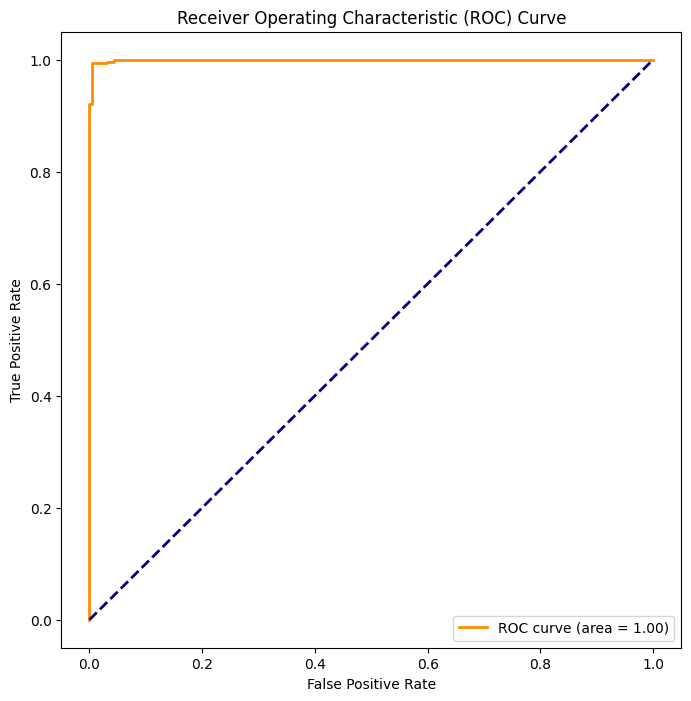

--------------------------------------------------
              precision    recall  f1-score   support

           0     0.9877    0.9640    0.9757       250
           1     0.9888    0.9962    0.9925       794

    accuracy                         0.9885      1044
   macro avg     0.9882    0.9801    0.9841      1044
weighted avg     0.9885    0.9885    0.9885      1044

--------------------------------------------------


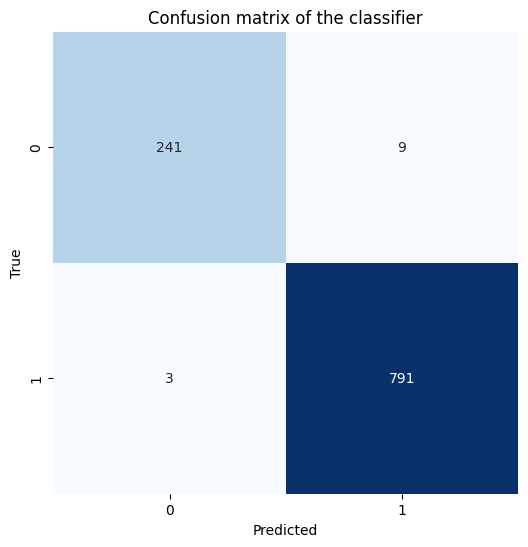

True Positives = 791 
False Positives = 9 
False Negatives = 3 
True Negatives = 241


In [ ]:
validate_FS(X, y, agent)  #aapso

In [ ]:
#ga 1


import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn import datasets
from math import e

# Genetic Algorithm for Feature Selection
#random initialization
def initialize_population(num_agents, num_features):
    population = np.random.randint(0, 2, size=(num_agents, num_features))
    return population

def fitness_function(agent, train_X, train_Y):
    # Evaluate fitness based on classification accuracy or some other objective
    selected_features = np.where(agent == 1)[0]
    if len(selected_features) == 0:
        return 0  # no features selected, so fitness is 0

    X_selected = train_X[:, selected_features]

    # Assume some classifier here, like SVM or Random Forest, and calculate accuracy
    # For the sake of simplicity, we use a dummy fitness function (replace with actual classifier)
    accuracy = np.random.random()  # Simulate some accuracy

    return accuracy


#single point crossover/one point crossover
#selection - Roulette Wheel Selection
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1) - 1)
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

#bit flip
def mutation(child, mutation_rate=0.01):
    for i in range(len(child)):
        if np.random.random() < mutation_rate:
            child[i] = 1 - child[i]  # Flip the bit
    return child

def genetic_algorithm(num_agents, max_iter, train_data, train_label, obj_function=fitness_function, crossover_rate=0.8, mutation_rate=0.01, save_conv_graph=False):
    short_name = 'GA'
    agent_name = 'Agent'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]

    # Initialize population
    population = initialize_population(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # Convergence curve
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)

    # Split dataset
    train_X, val_X, train_Y, val_Y = train_test_split(train_data, train_label, stratify=train_label, shuffle=True, test_size=0.4)

    # Start timer
    start_time = time.time()

    # Main loop (evolution)
    for iter_no in range(max_iter):
        print('\n================================================================================')
        print(f'                          Iteration - {iter_no+1}')
        print('================================================================================\n')

        # Evaluate fitness for each agent
        for i in range(num_agents):
            fitness[i] = obj_function(population[i], train_X, train_Y)

        # Select the best agent (leader)
        best_agent_idx = np.argmax(fitness)
        if fitness[best_agent_idx] > Leader_fitness:
            Leader_fitness = fitness[best_agent_idx]
            Leader_agent = population[best_agent_idx][:]

        # Create a new generation (crossover & mutation)
        new_population = []
        while len(new_population) < num_agents:
            # Select two parents (roulette-wheel or tournament selection)
            parents_idx = np.random.choice(num_agents, 2, p=fitness/np.sum(fitness))
            parent1, parent2 = population[parents_idx[0]], population[parents_idx[1]]

            # Crossover
            if np.random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()

            # Mutation
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)

            # Add to new population
            new_population.append(child1)
            new_population.append(child2)

        # Update population with the new generation
        population = np.array(new_population[:num_agents])

        # Convergence curve update
        convergence_curve['fitness'][iter_no] = Leader_fitness

    # Stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # Final evaluation
    final_accuracy = fitness[best_agent_idx]

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print(f'Leader {agent_name} Dimension: {int(np.sum(Leader_agent))}')
    print(f'Leader {agent_name} Fitness: {Leader_fitness}')
    print(f'Leader {agent_name} Classification Accuracy: {final_accuracy}')
    print('\n================================================================================\n')

    # Plot convergence graph
    def plot_convergence_curve(convergence_curve):
        plt.plot(convergence_curve['fitness'])
        plt.xlabel('Iterations')
        plt.ylabel('Fitness')
        plt.title('Convergence Curve')
        plt.show()

    if save_conv_graph:
        plot_convergence_curve(convergence_curve)

    # Return solution object (best agent, fitness, etc.)
    solution = {
        'best_agent': Leader_agent,
        'best_fitness': Leader_fitness,
        'best_accuracy': final_accuracy,
        'convergence_curve': convergence_curve,
        'execution_time': exec_time
    }

    return solution

# # Example usage
# # Example data
# from sklearn.datasets import load_iris
# X, y = load_iris(return_X_y=True)

# # Run GA
# fs_soln = genetic_algorithm(num_agents=30, max_iter=20, train_data=X, train_label=y)
# print(fs_soln)


In [ ]:
fs_soln = genetic_algorithm(num_agents=30, max_iter=20, train_data=X, train_label=y)
print(fs_soln)



                          Iteration - 1


                          Iteration - 2


                          Iteration - 3


                          Iteration - 4


                          Iteration - 5


                          Iteration - 6


                          Iteration - 7


                          Iteration - 8


                          Iteration - 9


                          Iteration - 10


                          Iteration - 11


                          Iteration - 12


                          Iteration - 13


                          Iteration - 14


                          Iteration - 15


                          Iteration - 16


                          Iteration - 17


                          Iteration - 18


                          Iteration - 19


                          Iteration - 20


                                    Final Result                                  

Leader Agent Dimension: 271
Leader Agent Fitness: 0.998526689592

In [ ]:
agent = fs_soln['best_agent'].copy()
print(agent)

[1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1
 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0
 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0
 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0
 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0
 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0
 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1
 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1
 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1
 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1
 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0
 1 0 0 1 1 0 0 1 0 0 1 1 

In [ ]:
fs_soln = genetic_algorithm(num_agents=30, max_iter=20, train_data=X, train_label=y)
print(fs_soln)

# Access best agent from the dictionary and make a copy
agent = fs_soln['best_agent'].copy()
print(agent)



                          Iteration - 1


                          Iteration - 2


                          Iteration - 3


                          Iteration - 4


                          Iteration - 5


                          Iteration - 6


                          Iteration - 7


                          Iteration - 8


                          Iteration - 9


                          Iteration - 10


                          Iteration - 11


                          Iteration - 12


                          Iteration - 13


                          Iteration - 14


                          Iteration - 15


                          Iteration - 16


                          Iteration - 17


                          Iteration - 18


                          Iteration - 19


                          Iteration - 20


                                    Final Result                                  

Leader Agent Dimension: 249
Leader Agent Fitness: 0.999933190886

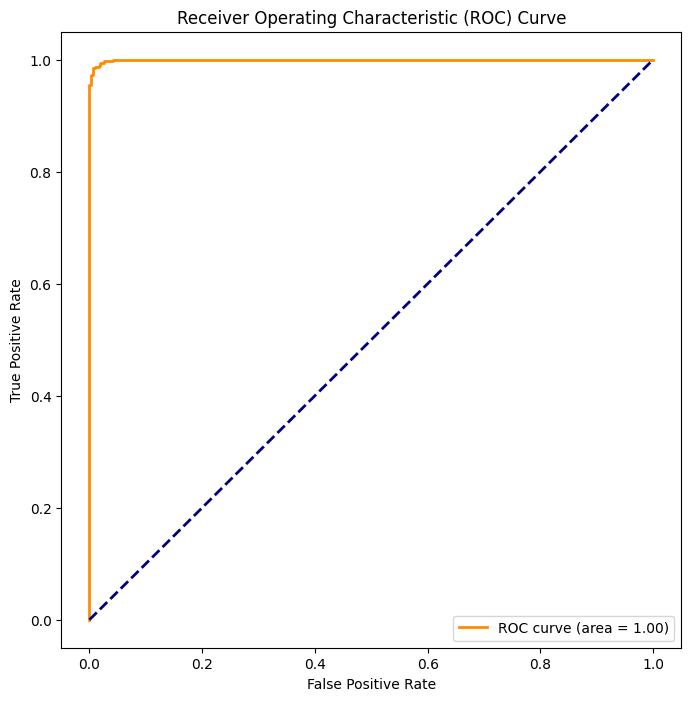

--------------------------------------------------
              precision    recall  f1-score   support

           0     0.9934    0.9676    0.9803       309
           1     0.9865    0.9973    0.9919       735

    accuracy                         0.9885      1044
   macro avg     0.9899    0.9825    0.9861      1044
weighted avg     0.9886    0.9885    0.9885      1044

--------------------------------------------------


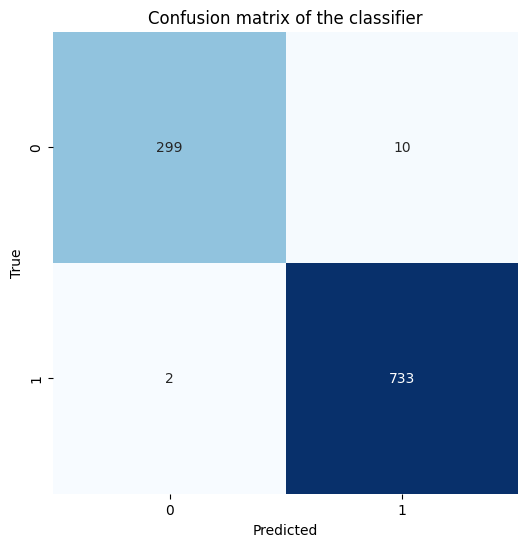

True Positives = 733 
False Positives = 10 
False Negatives = 2 
True Negatives = 299


In [ ]:
validate_FS(X, y, agent)  #ga